### Decoding from fMRI data

In this notebook we will use the Haxby et al. data that were prepared in the Data Setup notebook to perform classification.



In [1]:
import os
import h5py
import numpy as np
import nibabel as nib
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import f_classif, SelectKBest, VarianceThreshold
import warnings
from utils import (
    get_data_frame, 
    get_subject_runs,
    get_difumo_mask, 
    get_subject_common_brain_mask,
    get_layouts,
    get_combined_subject_difumo_mask
)
import tqdm
from torch.utils.data import TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import OneHotEncoder
from nilearn.image import resample_img
from nilearn.maskers import NiftiMasker
import nilearn.plotting
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import ToTensor
from bids import BIDSLayout
from collections import defaultdict

base_dir = "/Users/poldrack/data_unsynced/ds000105"
h5_file = os.path.join(base_dir, 'derivatives/cleaned/haxby_data_cleaned.h5')

device = 'cuda' if torch.cuda.is_available() else \
    "mps" if torch.backends.mps.is_available() else "cpu"   
print(f"Using device {device}")


Using device mps


### Load the data



In [2]:
def get_subject_data(subject, h5_file, bids_dir, data_key='vtmaskdata', condmeans=False):
    assert data_key in ['braindata', 'vtmaskdata']
    meanstr = 'mean_' if condmeans else ''
    runs = get_subject_runs(subject, bids_dir)
    X, metadata_df = None, None

    with h5py.File(h5_file, 'r') as hf:
        for run in runs:
            if X is None:
                X = hf[f'sub-{subject}/run-{run}/{meanstr + data_key}'][:]
            else:
                X = np.vstack((X, hf[f'sub-{subject}/run-{run}/{meanstr + data_key}'][:]))
            
            if metadata_df is None:
                conditions = [i.decode('utf-8') for i in hf[f'sub-{subject}/run-{run}/{meanstr}conditions'][:]]
                metadata_df = pd.DataFrame({'conditions': conditions, 'run': run})
            else:
                conditions = [i.decode('utf-8') for i in hf[f'sub-{subject}/run-{run}/{meanstr}conditions'][:]]
                metadata_df = pd.concat([metadata_df, pd.DataFrame({'conditions': conditions, 'run': run})])
    assert X.shape[0] == metadata_df.shape[0]
    return X, metadata_df

X, metadata_df = get_subject_data(1, h5_file, base_dir, condmeans=True, data_key='braindata')
print(X.shape)
metadata_df.head()



(96, 64441)


,conditions,run
0,bottle,1
1,cat,1
2,chair,1
3,face,1
4,house,1


### Run decoding model

Use a leave-one-run-out crossvalidation scheme

In [3]:

# leave one run out cross validation

def run_cv_subject(data, metadata_df, nfeatures=None, shuffle=False, 
           varthresh=None, clf=None, suppress_warnings=False):
    """
    Perform cross-validation for decoding analysis.

    Parameters:
    - data_df (pandas.DataFrame): The input data frame containing the features and labels.
    - nfeatures (int): The number of features to select using ANOVA. Default is 1000, or None to disable.
    - shuffle_y (bool): Whether to shuffle the labels. Default is False
    - varthresh (float): The variance threshold for feature selection. Default is 0, or None to disable.
    - clf (sklearn classifier): The classifier to use. Default is None, which uses a Support Vector Machine

    Returns:
    - accs (list): A list of accuracy scores for each cross-validation fold.
    """
    if clf is None:
        clf = SGDClassifier() # by default is like SVM with l2 regularization

    # Suppress warnings from scikit-learn
    if suppress_warnings:
        warnings.filterwarnings("ignore", category=UserWarning)
        warnings.filterwarnings("ignore", category=RuntimeWarning)

    # Leave one run out cross-validation
    logo = LeaveOneGroupOut()
    assert data.shape[0] == metadata_df.shape[0]

    if shuffle:
        metadata_df.conditions = np.random.permutation(metadata_df.conditions)

    # perform variance thresholding with default of zero
    if varthresh is not None:
        vt = VarianceThreshold(threshold=varthresh)
        vox_df = vt.fit_transform(data)

    accs = []
    coefs = None
    for train_index, test_index in logo.split(data, groups=metadata_df.run):
        train_X = data[train_index]
        assert train_X.shape[0] == len(train_index)
        assert train_X.shape[1] == data.shape[1]
        test_X = data[test_index]
        train_y = metadata_df.conditions.iloc[train_index]
        test_y = metadata_df.conditions.iloc[test_index]
        
        if nfeatures is not None:
            # Feature selection based on training data only
            selector = SelectKBest(score_func=f_classif, k=nfeatures)
            train_data_selected = selector.fit_transform(train_X, train_y)
            test_data_selected = selector.transform(test_X)
        else:
            train_data_selected = train_X
            test_data_selected = test_X

        clf.fit(train_data_selected, train_y)
        if hasattr(clf, 'coef_'):
            if coefs is None:
                coefs = clf.coef_ 
            else:

                coefs += clf.coef_ 
        acc = accuracy_score(test_y, clf.predict(test_data_selected))
        accs.append(acc)
    if coefs is not None:
        mean_coefs = coefs / len(accs)
    else:
        mean_coefs = None
    return accs, mean_coefs


def get_runs_from_hf(hf, subject):
    runs = [int(i.split('-')[-1]) for i in hf[subject].keys()]
    runs.sort()
    return runs


        
def run_cv(clf=None, shuffle=False, nfeatures=None, varthresh=None,
           data_key='braindata', condmeans=False):
    if clf is None:
        clf = SGDClassifier()
    print(f'Running cross-validation with {clf}')
    if nfeatures is not None:
        print(f'Selecting best {nfeatures} features: ')
    if varthresh is not None:
        print(f'Performing variance thresholding with threshold {varthresh}')
    if shuffle:
        print('Including shuffled data')
    accs = {}
    coefs = {}

    # would usually run this many more times for shuffled data
    nshuffles = 1
    shuffle_vals = [False, True] if shuffle else [False]

    for subject in range(1, 7):
        subdata, metadata_df = get_subject_data(subject, h5_file, 
                                                base_dir,condmeans=condmeans,
                                                data_key=data_key)
        print(f'Subject {subject}')
        print(f'data shape: {subdata.shape}')
        accs[subject] = {}
        for shuffle_y in shuffle_vals:
            shuffled_string = 'shuffled' if shuffle_y else 'orig'
            nruns = nshuffles if shuffle_y else 1
            accs[subject][shuffled_string] = 0
            for i in range(nshuffles):
                acc_, coef_ = run_cv_subject(subdata, metadata_df, nfeatures=nfeatures, 
                                    shuffle=shuffle_y, varthresh=varthresh, 
                                    clf=clf)
                if shuffle_y is False:
                    coefs[subject] = coef_
                accs[subject][shuffled_string] += np.mean(acc_)
            accs[subject][shuffled_string] /= nshuffles
            print(f'Mean accuracy ({shuffled_string}): {np.mean(accs[subject][shuffled_string]):.03}')

        print('')
    return accs, coefs


# run crossvalidation across subjects with default settings
# need to run without thresholding or feature selection to get the full set of coefs
accs, coefs = run_cv(shuffle=False, data_key='vtmaskdata', condmeans=True, 
                     varthresh=None, nfeatures=None)

results_df = pd.DataFrame({'SGD_l2': [accs[i]['orig'] for i in accs.keys()]})
results_df

Running cross-validation with SGDClassifier()
Subject 1
data shape: (96, 1404)
Mean accuracy (orig): 0.771

Subject 2
data shape: (96, 1114)
Mean accuracy (orig): 0.698

Subject 3
data shape: (96, 701)
Mean accuracy (orig): 0.771

Subject 4
data shape: (96, 1623)
Mean accuracy (orig): 0.677

Subject 5
data shape: (88, 893)
Mean accuracy (orig): 0.841

Subject 6
data shape: (96, 746)
Mean accuracy (orig): 0.75



,SGD_l2
0,0.770833
1,0.697917
2,0.770833
3,0.677083
4,0.840909
5,0.750000


#### Visualizing the coefficients


(8, 1404)


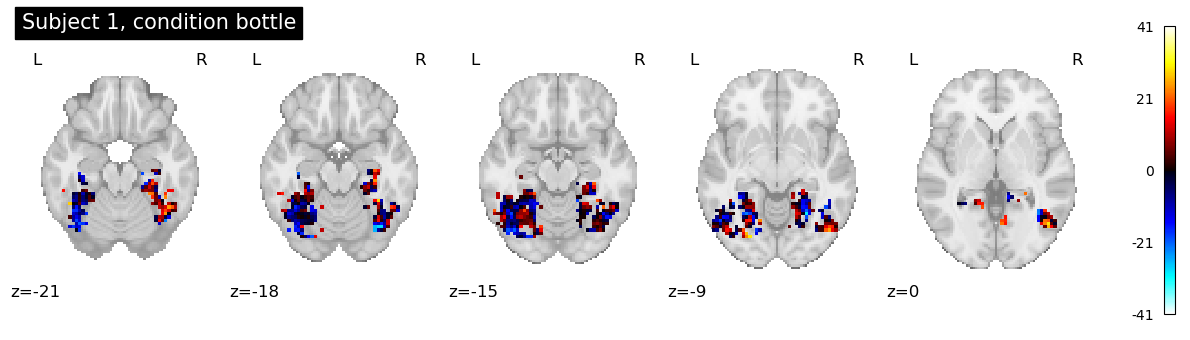

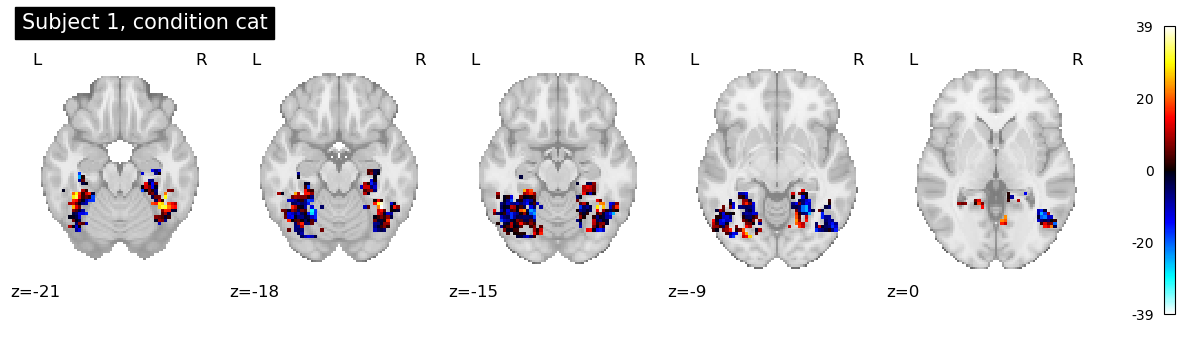

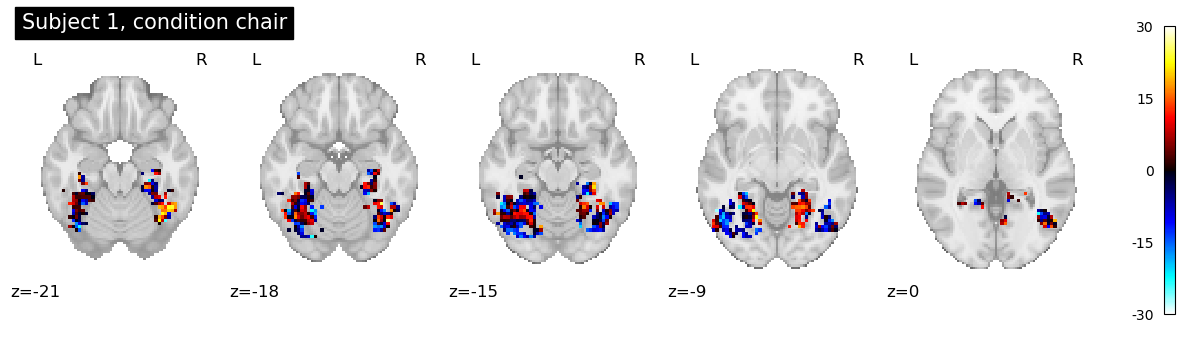

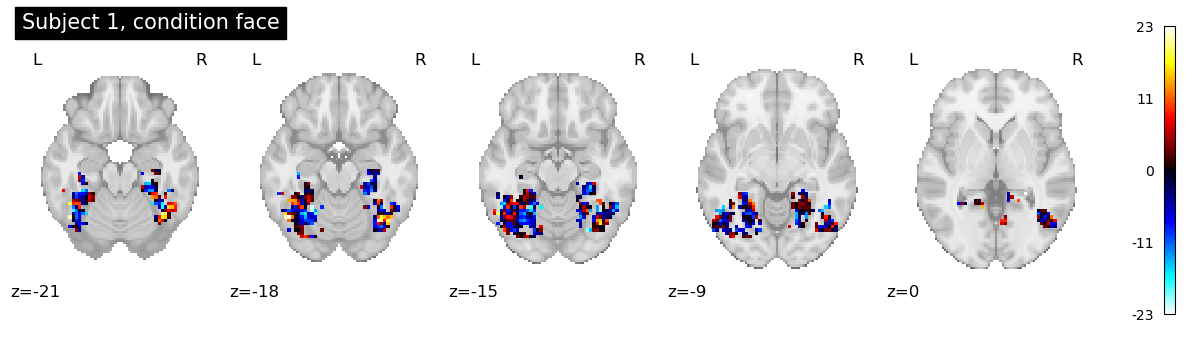

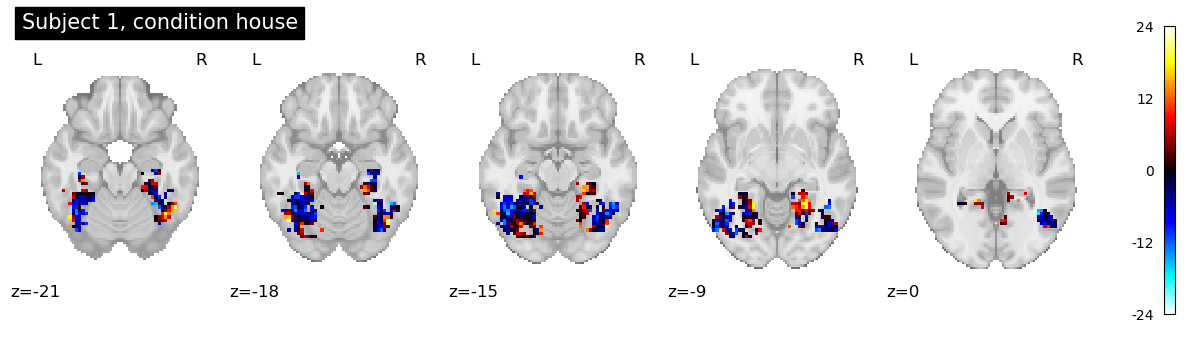

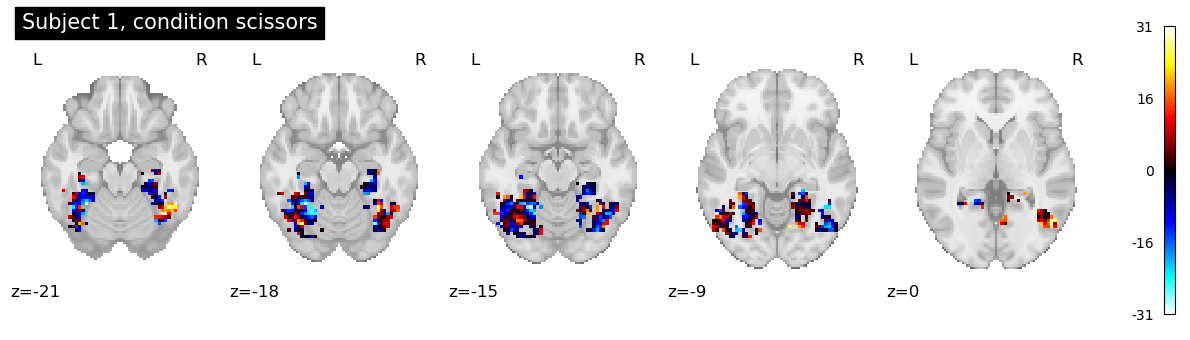

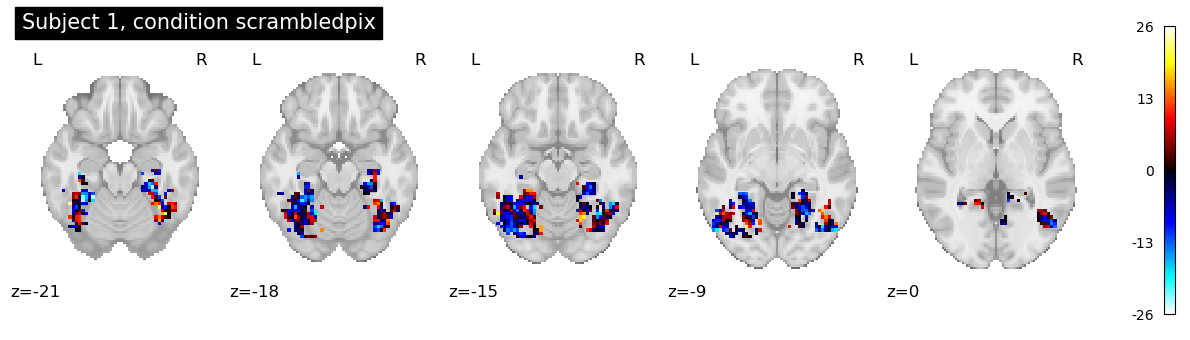

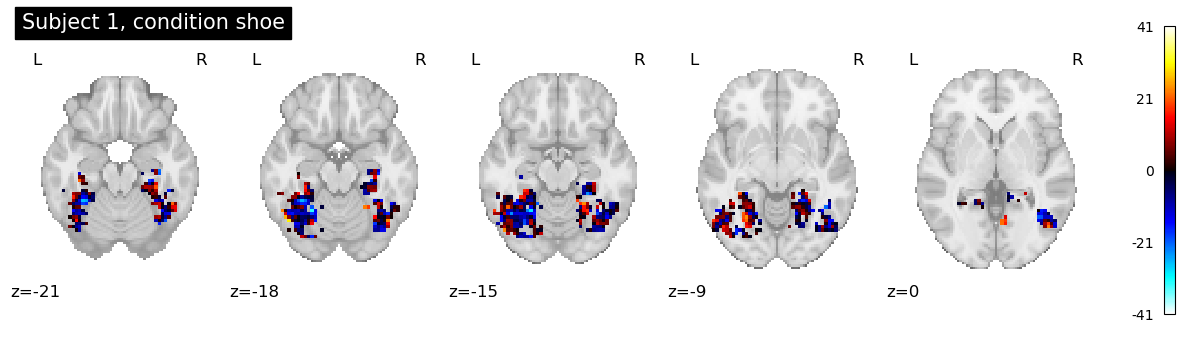

In [4]:
def get_subject_vt_mask(subject, vtmask_dir, res=3):
    vt_mask_file = os.path.join(vtmask_dir, f'sub-{subject}_mask4vt_space-MNI152NLin2009cAsym_res-{res}.nii.gz')
    return nib.load(vt_mask_file) 

def visualize_coefs(coefs, conditions, vtmask_dir):

    # plot the mean coefficients
    for subject in range(1, 2):
        mask_img = get_subject_vt_mask(subject, vtmask_dir)
        masker = NiftiMasker(mask_img)
        masker.fit()
        print(coefs[subject].shape)
        coef_img = masker.inverse_transform(coefs[subject])
        for c in range(coefs[subject].shape[0]):
            nilearn.plotting.plot_stat_map(coef_img.slicer[..., c], display_mode='z', 
                                           cut_coords=[-21, -18, -15, -9, 0],
                                           title=f'Subject {subject}, condition {conditions[c]}')

conditions = metadata_df.conditions.unique().tolist()
vtmask_dir = os.path.join(base_dir, 'derivatives/vtmasks')
visualize_coefs(coefs, conditions, vtmask_dir)


### Effect of different regularization schemes

In the previous model, we used a support vector machine with an L2 penalty, which penalizes the sum of squared weights. We can also look at the effect using a different penalty, namely an L1 penalty, which penalizes based on the sum of absolute weights, and leads in general to sparser solutions (more zero weights).

We can set the `LinearSVC` classifier to use L1 penalization.

Running cross-validation with SGDClassifier(alpha=0.01, penalty='l1')
Subject 1
data shape: (96, 1404)
Mean accuracy (orig): 0.719

Subject 2
data shape: (96, 1114)
Mean accuracy (orig): 0.635

Subject 3
data shape: (96, 701)
Mean accuracy (orig): 0.667

Subject 4
data shape: (96, 1623)
Mean accuracy (orig): 0.625

Subject 5
data shape: (88, 893)
Mean accuracy (orig): 0.818

Subject 6
data shape: (96, 746)
Mean accuracy (orig): 0.646

(8, 1404)


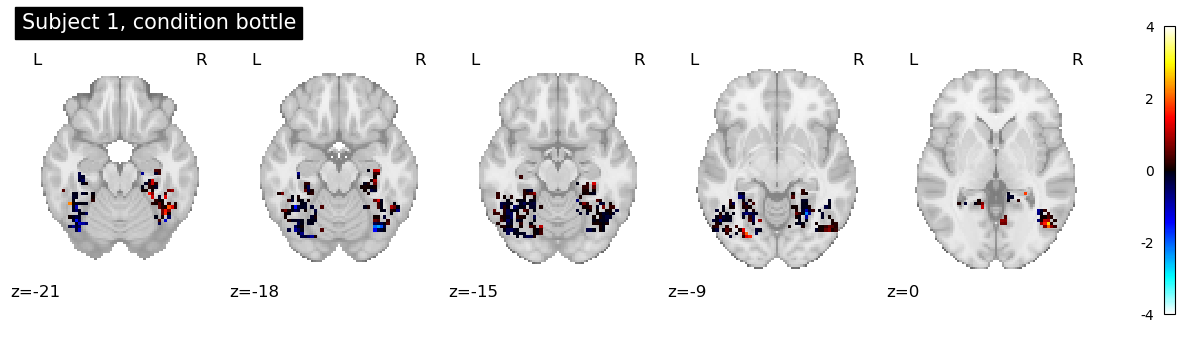

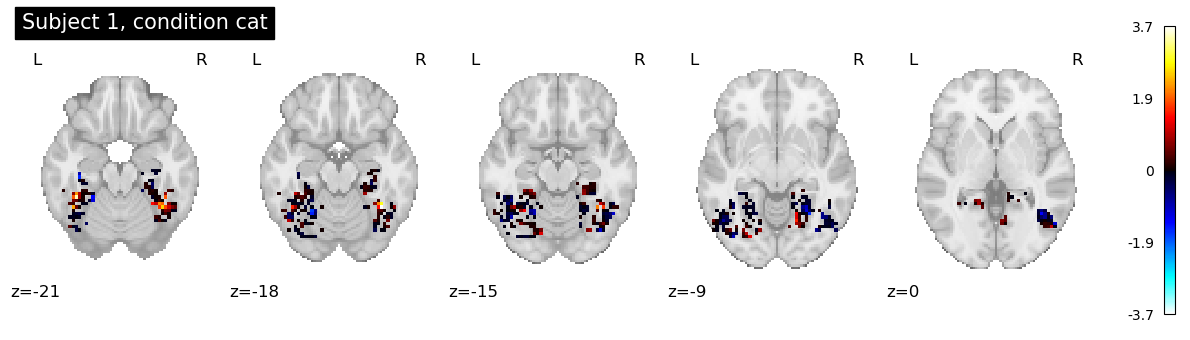

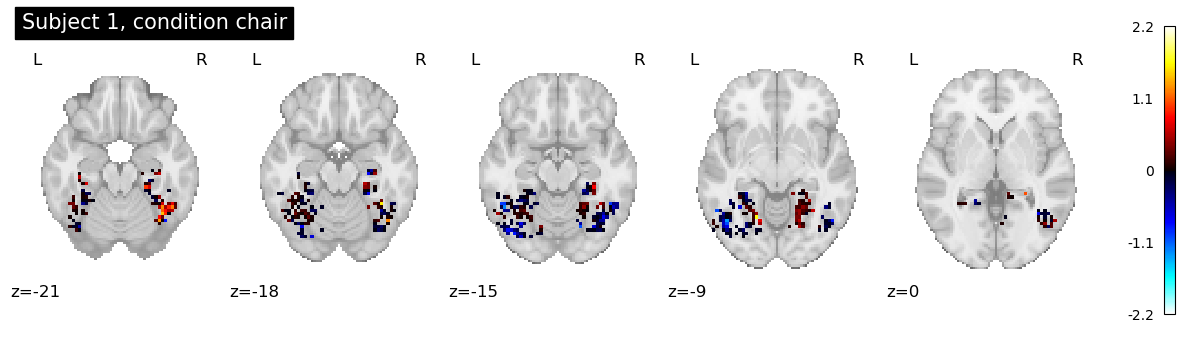

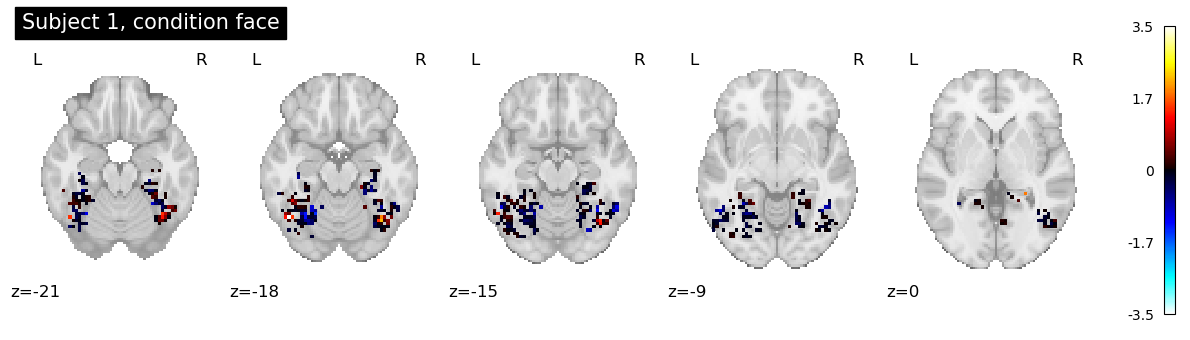

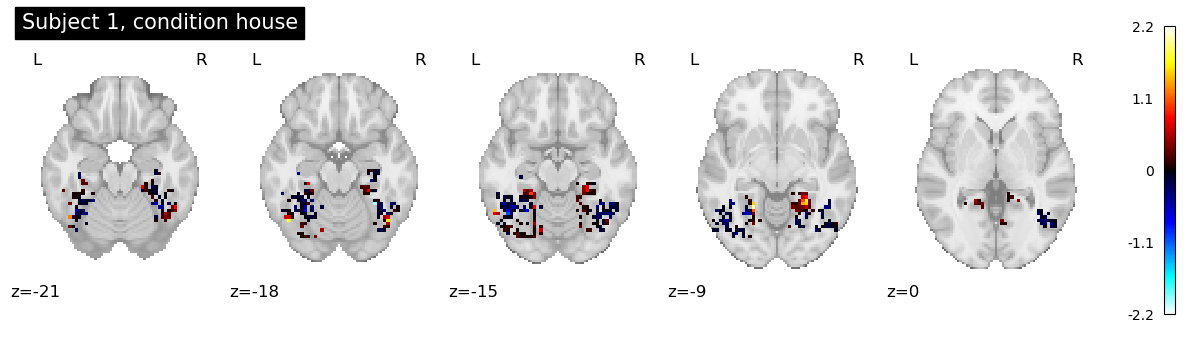

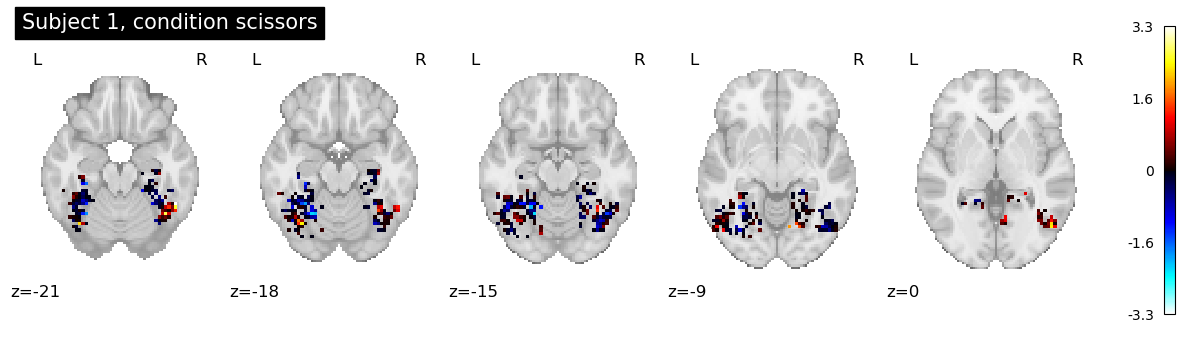

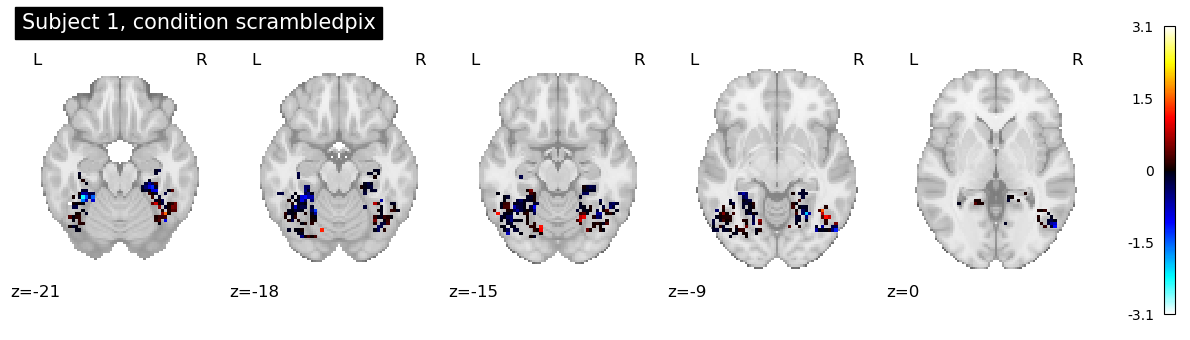

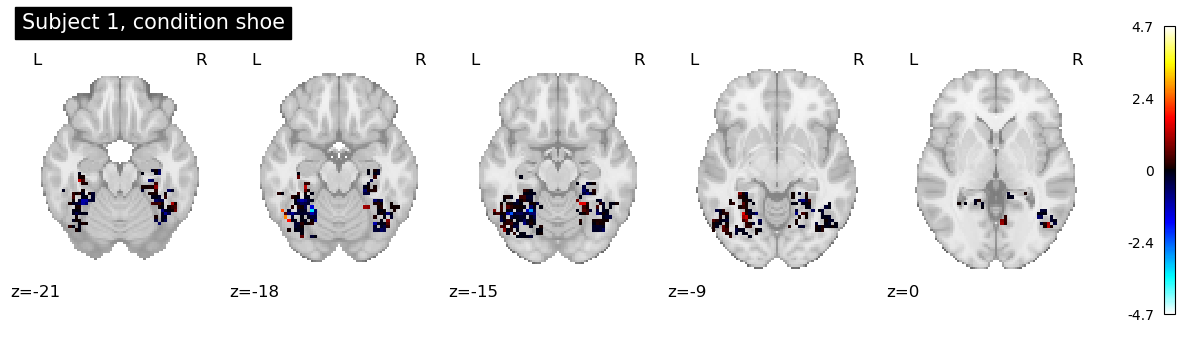

In [5]:


accs_L1, coefs_L1 = run_cv(shuffle=False, data_key='vtmaskdata', condmeans=True, 
                           clf=SGDClassifier(penalty='l1', alpha=0.01),
                           varthresh=None, nfeatures=None)
results_df['SGD_l1'] = [accs_L1[i]['orig'] for i in accs_L1.keys()]
visualize_coefs(coefs_L1, conditions, vtmask_dir)


### Multi-layer perceptron

Now we will use a nonlinear model: a multi-layer perceptron, which has a single layer of modifiable weights.  We use a single hidden layer with 100 units.

In [6]:
from sklearn.neural_network import MLPClassifier

accs_MLP, coefs_MLP = run_cv(shuffle=False, data_key='vtmaskdata', condmeans=True, 
                             clf=MLPClassifier(hidden_layer_sizes=(128), max_iter=500),
                             varthresh=None, nfeatures=None)
results_df['MLP'] = [accs_MLP[i]['orig'] for i in accs_MLP.keys()]

Running cross-validation with MLPClassifier(hidden_layer_sizes=128, max_iter=500)
Subject 1
data shape: (96, 1404)
Mean accuracy (orig): 0.812

Subject 2
data shape: (96, 1114)
Mean accuracy (orig): 0.781

Subject 3
data shape: (96, 701)
Mean accuracy (orig): 0.698

Subject 4
data shape: (96, 1623)
Mean accuracy (orig): 0.635

Subject 5
data shape: (88, 893)
Mean accuracy (orig): 0.92

Subject 6
data shape: (96, 746)
Mean accuracy (orig): 0.729



<Axes: >

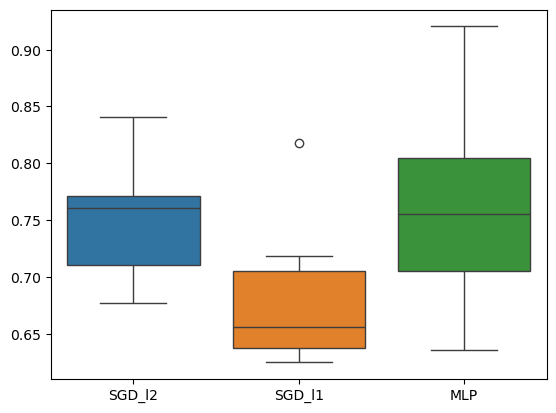

In [7]:
import seaborn as sns
sns.boxplot(data=results_df)